In [ ]:
import os
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
print('Notebook run using keras:', keras.__version__)

Notebook run using keras: 2.12.0


# Using Inception
Create a standard InceptionV3 pretrained model and use it on images by first preprocessing them with the preprocessing tools

In [ ]:
inet_model = inc_net.InceptionV3()

96112376/96112376 [==============================] - 2s 0us/step


In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = tf.keras.applications.inception_v3.preprocess_input(x)
        out.append(x)
    return np.vstack(out)


In [ ]:
current_dir = os.getcwd()
print("Current working directory:", current_dir)

Current working directory: /content


#Visualize the top 5 prediction for some image

35363/35363 [==============================] - 0s 0us/step
('n02133161', 'American_black_bear', 0.6372783)
('n02105056', 'groenendael', 0.031802893)
('n02104365', 'schipperke', 0.029921405)
('n01883070', 'wombat', 0.028507387)
('n01877812', 'wallaby', 0.025098704)


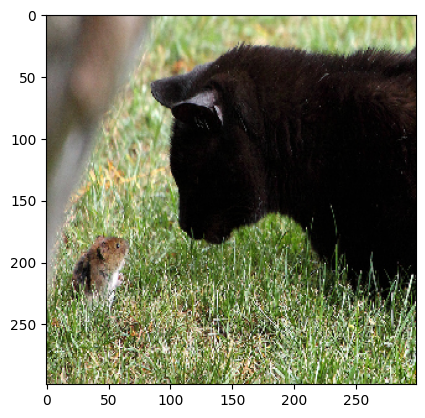

In [ ]:
images = transform_img_fn([os.path.join('/content/data','cat_mouse.jpg')])
# dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:#decodes to a readable format
    print(x)

In [ ]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283838 sha256=388170f8038f5d516c3286774a055ffe8ff71d7873af8265048e70cabaa149d2
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


## Explanation
Getting an explanation

In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
explainer = lime_image.LimeImageExplainer() #create instance of the explainer

In [ ]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double') #converts the mg to numpy array with double vals

                                         , inet_model.predict #returns the blac-box predictions
                                         , top_labels=5 #top 5 (highest prob)labels will be considered for explainability
                                         , hide_color=0, # the superpixels will be colored according to their weights (importance) in the explanation. If set to None, the original image's color will be used for superpixels.
                                         num_samples=1000) #number of perturbed instances

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step
CPU times: user 6min 48s, sys: 9.48 s, total: 6min 57s
Wall time: 5min 50s


### Now let's see the explanation for the top class ( Black Bear)

In [ ]:
from skimage.segmentation import mark_boundaries

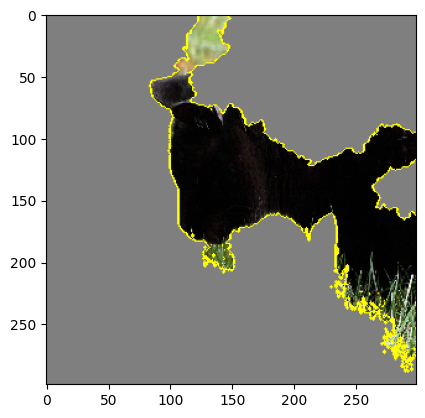

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],#generate explanation for that particular class
                                            positive_only=True, #focus only on the positive contributions of the features
                                            num_features=5,
                                            hide_rest=True)
#temp is a 2D NumPy array representing the explanation overlayed on the original image, and mask is a binary mask indicating the important regions (superpixels) in the image.
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or with the rest of the image present:

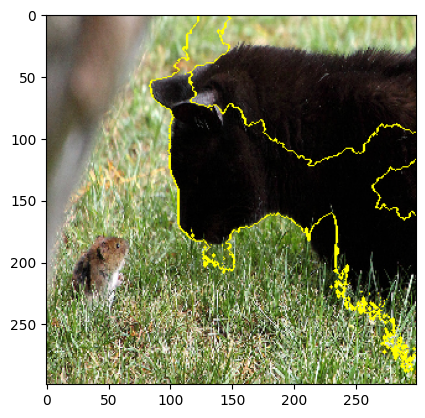

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))


We can also see the 'pros and cons' (pros in green, cons in red)

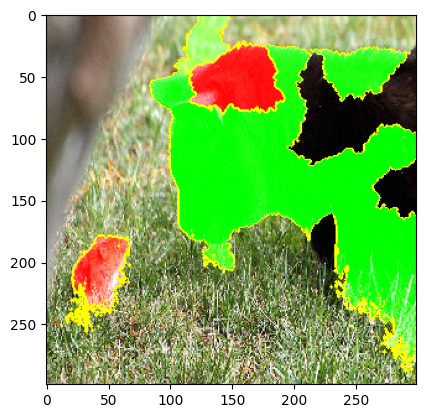

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10,#sets the number of top superpixels to include
                                            hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Or the pros and cons that have weight at least 0.1

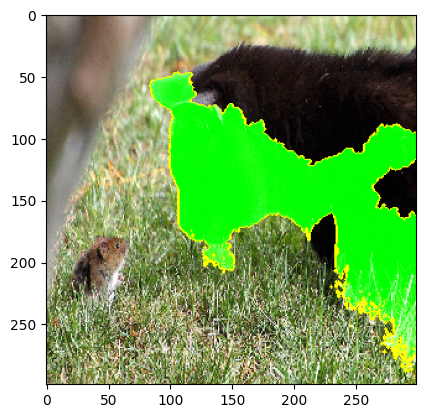

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Alternatively, we can also plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

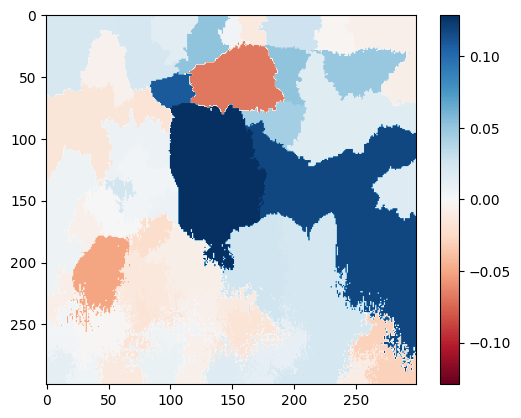

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

### The Explanation for the second highest prediction

Most positive towards wombat:

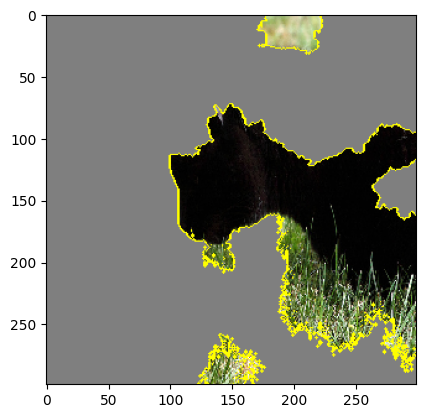

In [ ]:
temp, mask = explanation.get_image_and_mask(106, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Pros and cons:

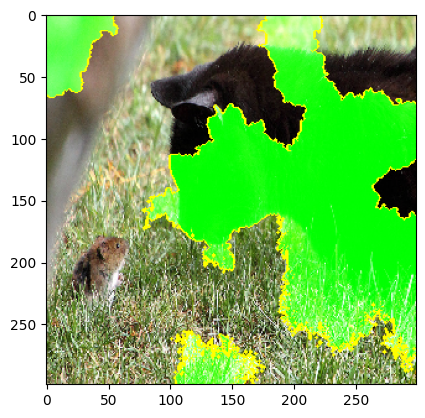

In [ ]:
temp, mask = explanation.get_image_and_mask(106, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
